In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import re
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
stops = set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
p_stemmer = PorterStemmer()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV 
%matplotlib inline

In [2]:
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
df=pd.read_csv('Pol03-06-2018.csv')

df.shape

(3382, 18)

In [5]:
df.shape

(3382, 18)

/Users/admin/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


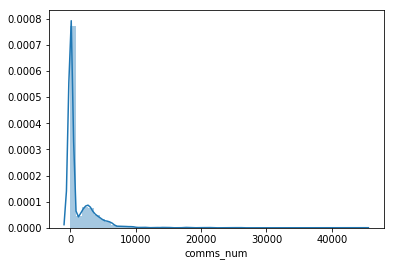

In [6]:
sns.distplot(df['comms_num']);


/Users/admin/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


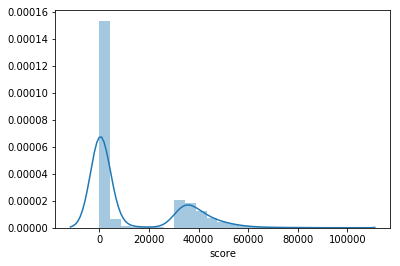

In [7]:
sns.distplot(df['score']);

In [8]:
print('Scores')
print("Mean is {:0.2f} and the Median is {:0.2f}".format(np.mean(df.score),np.median(df.score)))
print('Number of coments')
print("Mean is {:0.2f} and the Median is {:0.2f}".format(np.mean(df.comms_num),np.median(df.comms_num)))



Scores
Mean is 12540.25 and the Median is 375.00
Number of coments
Mean is 1313.90 and the Median is 40.00


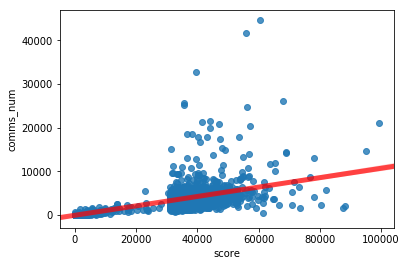

In [9]:
#Examine the relationship between score and number of comments 
sns.regplot(x=df['score'], y=df["comms_num"], 
            line_kws={"color":"r","alpha":0.7,"lw":5});

There is low correlation between the variables

In [10]:
df['score'].corr(df['comms_num'])

0.7251167559372578

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3382 entries, 0 to 3381
Data columns (total 18 columns):
body                37 non-null object
comms_num           3382 non-null int64
created             3382 non-null float64
domain              3382 non-null object
id                  3382 non-null object
score               3382 non-null int64
subreddit           3382 non-null object
time_retrieved      3382 non-null object
title               3382 non-null object
time                3382 non-null object
time_retrieved.1    3382 non-null object
post_duration       3382 non-null float64
time_hm             3382 non-null int64
day                 3382 non-null object
word_count          3382 non-null int64
sent_sia            3382 non-null float64
sentiment           3382 non-null float64
subjectivity        3382 non-null float64
dtypes: float64(5), int64(4), object(9)
memory usage: 475.7+ KB


In [12]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = df.select_dtypes(include = ["object"]).columns
numerical_features = df.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop(["score","comms_num"])
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
df_num = df[numerical_features]
df_cat = df[categorical_features]

Numerical features : 7
Categorical features : 9


In [13]:
# from scipy.stats import skew
# # Log transform of the skewed numerical features to lessen impact of outliers
# # Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# # As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
# df['log_coms']= np.loglp(df['log_coms'])
# df['log_score']= np.loglp(df['score'])
# # train["SalePrice"] = np.log1p(train["SalePrice"])

In [14]:
df.head(2)

,body,comms_num,created,domain,id,score,subreddit,time_retrieved,title,time,time_retrieved.1,post_duration,time_hm,day,word_count,sent_sia,sentiment,subjectivity
0,NaN,541,1.527738e+09,abcnews.go.com,8nbldk,1519,politics,2018-05-30 22:07:10.938189+00:00,Melania Trump Not Seen by Public in 20 Days,2018-05-31 03:45:37.000000,2018-05-30 22:07:10.938189,18.0,3,Sun,9,-0.68,0.00,0.07
1,NaN,124,1.527717e+09,thinkprogress.org,8n8qnw,2600,politics,2018-05-30 22:07:10.938189+00:00,The ‘Don’t Vote Early’ campaign and the pro-Tr...,2018-05-30 21:53:16.000000,2018-05-30 22:07:10.938189,0.0,21,Sun,13,0.66,-0.03,0.37


In [15]:
df['sent_label'] = 'neutral'
df.loc[df['sentiment'] > 0.1, 'sent_label'] = 'positive'
df.loc[df['sentiment'] < -0.1, 'sent_label'] = 'negative'
df.head(3)
    

,body,comms_num,created,domain,id,score,subreddit,time_retrieved,title,time,time_retrieved.1,post_duration,time_hm,day,word_count,sent_sia,sentiment,subjectivity,sent_label
0,NaN,541,1.527738e+09,abcnews.go.com,8nbldk,1519,politics,2018-05-30 22:07:10.938189+00:00,Melania Trump Not Seen by Public in 20 Days,2018-05-31 03:45:37.000000,2018-05-30 22:07:10.938189,18.0,3,Sun,9,-0.68,0.00,0.07,neutral
1,NaN,124,1.527717e+09,thinkprogress.org,8n8qnw,2600,politics,2018-05-30 22:07:10.938189+00:00,The ‘Don’t Vote Early’ campaign and the pro-Tr...,2018-05-30 21:53:16.000000,2018-05-30 22:07:10.938189,0.0,21,Sun,13,0.66,-0.03,0.37,neutral
2,NaN,31,1.527737e+09,theguardian.com,8nbemi,551,politics,2018-05-30 22:07:10.938189+00:00,Ambien manufacturer responds to Roseanne blami...,2018-05-31 03:22:42.000000,2018-05-30 22:07:10.938189,19.0,3,Sun,25,-0.15,0.00,0.00,neutral


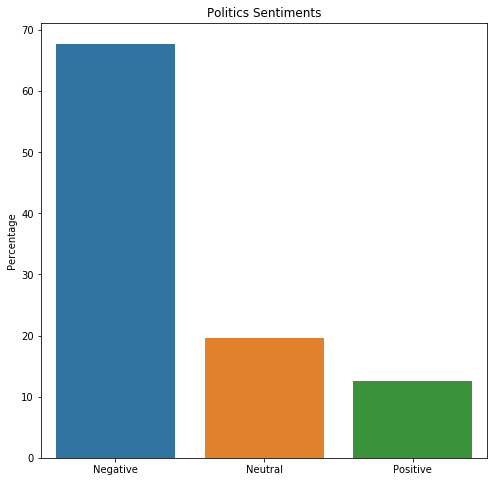

In [75]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = df.sent_label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")
ax.set_title("Politics Sentiments")
plt.show()

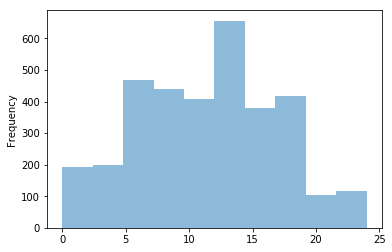

In [17]:
df['post_duration'].plot(kind='hist', alpha=.5);

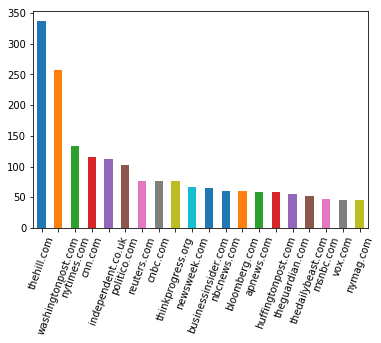

In [18]:
df['domain'].value_counts().head(20).plot(kind='bar')
plt.xticks(rotation=70);

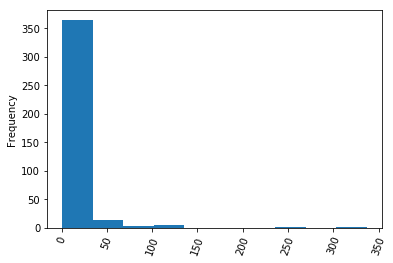

In [19]:
df['domain'].value_counts().plot(kind='hist')
plt.xticks(rotation=70);

In [20]:
DD= df['domain'].value_counts().head(30).index.tolist() 

df['domain_d'] = [type_ if type_ in DD
                      else "OTHER" for type_ in df['domain']]
df['domain_d'].value_counts()

OTHER                    1166
thehill.com               337
washingtonpost.com        257
nytimes.com               133
cnn.com                   115
independent.co.uk         113
politico.com              103
cnbc.com                   77
thinkprogress.org          77
reuters.com                77
newsweek.com               67
businessinsider.com        66
bloomberg.com              60
nbcnews.com                60
huffingtonpost.com         59
apnews.com                 59
theguardian.com            55
thedailybeast.com          52
msnbc.com                  47
vox.com                    46
nymag.com                  45
usatoday.com               39
self.politics              37
slate.com                  33
abcnews.go.com             32
cbsnews.com                32
talkingpointsmemo.com      29
latimes.com                28
npr.org                    28
axios.com                  27
salon.com                  26
Name: domain_d, dtype: int64

In [21]:
df['word_count'] = df['word_count'].round(2)

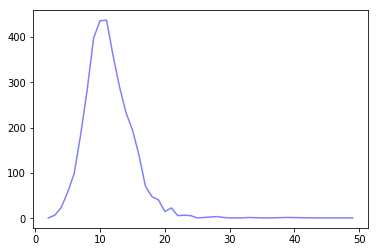

In [22]:
df['word_count'].value_counts().sort_index().plot(color='b', alpha=.5);

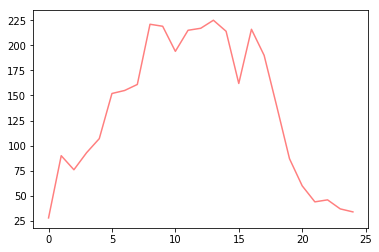

In [23]:
df['post_duration'].value_counts().sort_index().plot(color='r', alpha=.5);

In [24]:
le=LabelEncoder()
X = df[['word_count','sentiment','subjectivity','domain','post_duration']]
X_n=df[['word_count','sentiment','subjectivity','domain','title','post_duration']]
# y=df_combined['subreddit']
# transform the label 
y = le.fit_transform(df['subreddit'])

## Feature Engineering

In [25]:
print('Scores')
print("Mean is {:0.2f} and the Median is {:0.2f}".format(np.mean(df.score),np.median(df.score)))
print('Number of coments')
print("Mean is {:0.2f} and the Median is {:0.2f}".format(np.mean(df.comms_num),np.median(df.comms_num)))



Scores
Mean is 12540.25 and the Median is 375.00
Number of coments
Mean is 1313.90 and the Median is 40.00


In [26]:
df['com_label'] = np.where(df['comms_num']>=np.median(df.comms_num), 'High', 'Low')
df['score_label'] = np.where(df['score']>=np.median(df.score), 'High', 'Low')

In [27]:
#non_nlp variables 
X = df[['word_count','sentiment','subjectivity','domain_d','post_duration']]
# y=df_combined['subreddit']
# transform the label 



y_cm = LabelEncoder().fit_transform(df['com_label'])#Comments
y_sc = LabelEncoder().fit_transform(df['score_label'])# Score


In [28]:

df.corr()

,comms_num,created,score,post_duration,time_hm,word_count,sent_sia,sentiment,subjectivity
comms_num,1.000000,-0.608510,0.725117,-0.029764,-0.024800,0.047242,-0.006554,0.004426,-0.015767
created,-0.608510,1.000000,-0.761700,-0.011982,-0.016132,-0.165335,-0.024147,-0.004933,-0.013487
score,0.725117,-0.761700,1.000000,-0.020909,-0.033040,0.154891,0.006988,-0.003247,-0.002935
post_duration,-0.029764,-0.011982,-0.020909,1.000000,0.416369,0.039808,-0.017729,0.000552,0.021432
time_hm,-0.024800,-0.016132,-0.033040,0.416369,1.000000,0.025175,0.017591,0.018777,0.008181
word_count,0.047242,-0.165335,0.154891,0.039808,0.025175,1.000000,0.019472,0.062605,0.155883
sent_sia,-0.006554,-0.024147,0.006988,-0.017729,0.017591,0.019472,1.000000,-0.019781,0.010567
sentiment,0.004426,-0.004933,-0.003247,0.000552,0.018777,0.062605,-0.019781,1.000000,0.058753
subjectivity,-0.015767,-0.013487,-0.002935,0.021432,0.008181,0.155883,0.010567,0.058753,1.000000


In [29]:
def corr_map(df, figsize=(20,10), mask_val = None):
    # Make correlation heat map from pandas dataframe
    # pass a value to mask_val to only see correlations
    # above a certain value (the absolute value of the correlation)

    # Arguments:
    # df - pandas dataframe to with data for heatmap
    # figsize - size of resulting figure (width, height), default: (15, 10) (inches?)
    # mask_val - threshold for displaying correlations, default: None

    corr = df.corr()    
    
    # Make mask to only show bottom triangle
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(corr)] = True
    
    # Add to the mask (if mask_val passed)
    if (mask_val != None):
        mask[abs(corr) < mask_val] = True
    
    # Make heatmap
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2g')
    pass

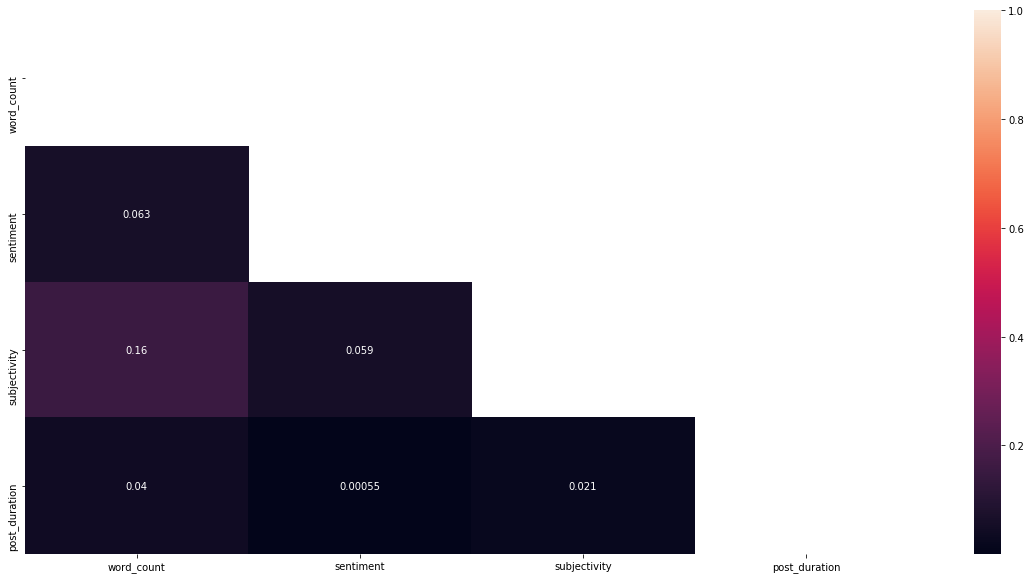

In [30]:
corr_map(X)

Correlation between word count and subjectivity .. verbose people are more objective?

In [31]:
df['domain_d'].nunique()

31

In [32]:
#286 domains .. need to condense
DD= df['domain'].value_counts().head(30).index.tolist()


df['domain_d'] = [type_ if type_ in DD
                      else "OTHER" for type_ in df['domain']]
print(df['domain_d'].nunique())

31


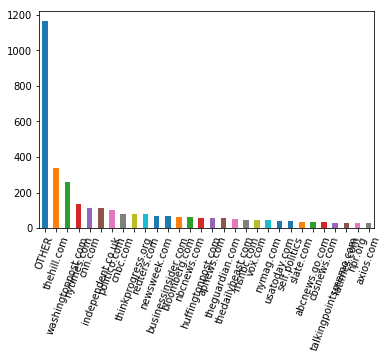

In [33]:
df['domain_d'].value_counts().head(30).plot(kind='bar')
plt.xticks(rotation=70);

***Text Preprossesing**

In [34]:
df['text']=df['title'].str.replace('\d+', '')
# df_lib_con.title = df_lib_con.title.str.replace('\d+', '')

def process_lem(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    tokens = word_tokenize(text)
    
    lemmer = WordNetLemmatizer()
    stop_words = stopwords.words("english")
    return ' '.join([lemmer.lemmatize(word) for word in tokens if not word in stop_words])

df['text'] = [process_lem(text) for text in df['text']]




In [35]:
df.head(5)

,body,comms_num,created,domain,id,score,subreddit,time_retrieved,title,time,...,day,word_count,sent_sia,sentiment,subjectivity,sent_label,domain_d,com_label,score_label,text
0,NaN,541,1.527738e+09,abcnews.go.com,8nbldk,1519,politics,2018-05-30 22:07:10.938189+00:00,Melania Trump Not Seen by Public in 20 Days,2018-05-31 03:45:37.000000,...,Sun,9,-0.68,0.00,0.07,neutral,abcnews.go.com,High,High,melania trump seen public day
1,NaN,124,1.527717e+09,thinkprogress.org,8n8qnw,2600,politics,2018-05-30 22:07:10.938189+00:00,The ‘Don’t Vote Early’ campaign and the pro-Tr...,2018-05-30 21:53:16.000000,...,Sun,13,0.66,-0.03,0.37,neutral,thinkprogress.org,High,High,vote early campaign pro trump effort suppress ...
2,NaN,31,1.527737e+09,theguardian.com,8nbemi,551,politics,2018-05-30 22:07:10.938189+00:00,Ambien manufacturer responds to Roseanne blami...,2018-05-31 03:22:42.000000,...,Sun,25,-0.15,0.00,0.00,neutral,theguardian.com,Low,High,ambien manufacturer responds roseanne blaming ...
3,NaN,129,1.527722e+09,democracynow.org,8n9em0,674,politics,2018-05-30 22:07:10.938189+00:00,39 Arrested Protesting Industrial Farm Supplyi...,2018-05-30 23:19:04.000000,...,Sun,14,-0.18,0.20,0.40,positive,OTHER,High,High,arrested protesting industrial farm supplying ...
4,NaN,26,1.527734e+09,huffingtonpost.com,8naytr,149,politics,2018-05-30 22:07:10.938189+00:00,Twitter Users Eviscerate Donald Trump’s Bizarr...,2018-05-31 02:29:07.000000,...,Sun,8,-0.78,0.40,0.60,positive,huffingtonpost.com,Low,Low,twitter user eviscerate donald trump bizarre r...


In [36]:
#non_nlp variables 

X = df[['word_count','sentiment','subjectivity','domain_d','post_duration','title','text']]
# y=df_combined['subreddit']
# transform the label 

le=LabelEncoder()

y_cm = le.fit_transform(df['com_label'])#Comments
y_sc = le.fit_transform(df['score_label'])# Score


In [37]:
X_d = pd.get_dummies(X, columns=['domain_d'], drop_first=True)

In [38]:
X_d.head(2)

,word_count,sentiment,subjectivity,post_duration,title,text,domain_d_abcnews.go.com,domain_d_apnews.com,domain_d_axios.com,domain_d_bloomberg.com,...,domain_d_self.politics,domain_d_slate.com,domain_d_talkingpointsmemo.com,domain_d_thedailybeast.com,domain_d_theguardian.com,domain_d_thehill.com,domain_d_thinkprogress.org,domain_d_usatoday.com,domain_d_vox.com,domain_d_washingtonpost.com
0,9,0.00,0.07,18.0,Melania Trump Not Seen by Public in 20 Days,melania trump seen public day,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,13,-0.03,0.37,0.0,The ‘Don’t Vote Early’ campaign and the pro-Tr...,vote early campaign pro trump effort suppress ...,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [39]:
y_cm.shape

(3382,)

Non-NLP **Comments**

In [40]:
X_c=X_d.drop(['title','text'],axis=1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_c, y_cm, test_size=0.5, random_state=42)

In [42]:
forest = RandomForestClassifier(max_depth=10, n_estimators=5)
lr=LogisticRegression()

In [43]:
lr.fit(X_train, y_train)
print('Log Reg')
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

forest.fit(X_train, y_train)
print('\n Random Forest')
print(forest.score(X_train, y_train))
print(forest.score(X_test, y_test))

Log Reg
0.63571850975754
0.6345357776463632

 Random Forest
0.6830277942046127
0.5890005913660555


In [44]:
from tpot import TPOTClassifier

tpot=TPOTClassifier()

tpot = TPOTClassifier(generations=3, population_size=20, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_pipeline.py')

Optimization Progress:  50%|█████     | 40/80 [00:52<01:43,  2.58s/pipeline]

Generation 1 - Current best internal CV score: 0.6215396310584098


Optimization Progress:  75%|███████▌  | 60/80 [01:25<00:26,  1.31s/pipeline]

Generation 2 - Current best internal CV score: 0.6215396310584098


Generation 3 - Current best internal CV score: 0.6280363402685659

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=2, max_features=0.3, min_samples_leaf=9, min_samples_split=14, n_estimators=100, subsample=0.8500000000000001)
0.6309875813128326


True

Non-NLP **Score**

In [45]:
X_s=X_d.drop(['title','text'],axis=1)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y_sc, test_size=0.5, random_state=42)

In [47]:
forest = RandomForestClassifier(max_depth=10, n_estimators=5)
lr=LogisticRegression()

In [48]:
lr.fit(X_train, y_train)
print('Log Reg')
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

forest.fit(X_train, y_train)
print('\n Random Forest')
print(forest.score(X_train, y_train))
print(forest.score(X_test, y_test))

Log Reg
0.6410408042578356
0.6120638675340035

 Random Forest
0.7013601419278533
0.6191602602010644


In [49]:
from tpot import TPOTClassifier

tpot=TPOTClassifier()

tpot = TPOTClassifier(generations=3, population_size=20, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_pipeline.py')

Optimization Progress:  50%|█████     | 40/80 [00:54<00:57,  1.44s/pipeline]

Generation 1 - Current best internal CV score: 0.6327402499820403


Optimization Progress:  75%|███████▌  | 60/80 [01:20<00:12,  1.58pipeline/s]

Generation 2 - Current best internal CV score: 0.6327402499820403


Generation 3 - Current best internal CV score: 0.6327402499820403

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, nthread=1, subsample=0.6500000000000001)


ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33'] ['word_count', 'sentiment', 'subjectivity', 'post_duration', 'domain_d_abcnews.go.com', 'domain_d_apnews.com', 'domain_d_axios.com', 'domain_d_bloomberg.com', 'domain_d_businessinsider.com', 'domain_d_cbsnews.com', 'domain_d_cnbc.com', 'domain_d_cnn.com', 'domain_d_huffingtonpost.com', 'domain_d_independent.co.uk', 'domain_d_latimes.com', 'domain_d_msnbc.com', 'domain_d_nbcnews.com', 'domain_d_newsweek.com', 'domain_d_npr.org', 'domain_d_nymag.com', 'domain_d_nytimes.com', 'domain_d_politico.com', 'domain_d_reuters.com', 'domain_d_salon.com', 'domain_d_self.politics', 'domain_d_slate.com', 'domain_d_talkingpointsmemo.com', 'domain_d_thedailybeast.com', 'domain_d_theguardian.com', 'domain_d_thehill.com', 'domain_d_thinkprogress.org', 'domain_d_usatoday.com', 'domain_d_vox.com', 'domain_d_washingtonpost.com']
expected f31, f10, f16, f12, f3, f28, f6, f15, f18, f2, f26, f5, f8, f24, f7, f25, f4, f9, f20, f23, f0, f29, f14, f17, f13, f21, f27, f19, f30, f1, f32, f22, f11, f33 in input data
training data did not have the following fields: domain_d_latimes.com, domain_d_apnews.com, domain_d_bloomberg.com, domain_d_vox.com, domain_d_thinkprogress.org, domain_d_nbcnews.com, post_duration, domain_d_cbsnews.com, domain_d_cnn.com, domain_d_nymag.com, domain_d_cnbc.com, domain_d_reuters.com, domain_d_huffingtonpost.com, sentiment, domain_d_washingtonpost.com, domain_d_self.politics, domain_d_slate.com, domain_d_independent.co.uk, domain_d_nytimes.com, domain_d_politico.com, domain_d_talkingpointsmemo.com, domain_d_axios.com, domain_d_theguardian.com, domain_d_abcnews.go.com, domain_d_msnbc.com, domain_d_npr.org, word_count, subjectivity, domain_d_salon.com, domain_d_thehill.com, domain_d_businessinsider.com, domain_d_thedailybeast.com, domain_d_newsweek.com, domain_d_usatoday.com

**NLP-score**


In [50]:
X_s_n=X_d

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_s_n, y_sc, test_size=0.5, random_state=42)

In [52]:
tvec = TfidfVectorizer(stop_words=stopwords.words('english'),
                                 lowercase=True,max_features=500)

X_train_matrix = tvec.fit_transform(X_train['text'])
X_test_matrix = tvec.transform(X_test['text'])

In [53]:
forest = RandomForestClassifier(max_depth=10, n_estimators=5)
lr=LogisticRegression()

In [54]:
X_train_df = pd.DataFrame(X_train_matrix.todense(),
                         columns=tvec.get_feature_names(),
                         index=X_train.index)

In [55]:
X_test_df = pd.DataFrame(X_test_matrix.todense(),
                        columns=tvec.get_feature_names(),
                        index=X_test.index)

In [56]:
X_train_all = pd.concat([X_train_df, X_train.drop('title', axis=1)], axis=1)
X_test_all = pd.concat([X_test_df, X_test.drop('title', axis=1)], axis=1)

In [57]:
forest = RandomForestClassifier(max_depth=10, n_estimators=5)
lr=LogisticRegression()

In [58]:
lr.fit(X_train_matrix, y_train)
print('Log Reg')
print(lr.score(X_train_matrix, y_train))
print(lr.score(X_test_matrix, y_test))

forest.fit(X_train_matrix, y_train)
print('\n Random Forest')
print(forest.score(X_train_matrix, y_train))
print(forest.score(X_test_matrix, y_test))

Log Reg
0.7912477823772915
0.6599645180366647

 Random Forest
0.7114133648728563
0.6221170904790065


Worse by itself .. lets see if it'll improve

**NLP-comments**


In [59]:
X_cm_n=X_d

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_s_n, y_sc, test_size=0.5, random_state=42)

In [61]:
tvec = TfidfVectorizer(stop_words=stopwords.words('english'),
                                 lowercase=True,max_features=500)

X_train_matrix = tvec.fit_transform(X_train['text'])
X_test_matrix = tvec.transform(X_test['text'])

In [62]:
forest = RandomForestClassifier(max_depth=10, n_estimators=5)
lr=LogisticRegression()

In [63]:
X_train_df = pd.DataFrame(X_train_matrix.todense(),
                         columns=tvec.get_feature_names(),
                         index=X_train.index)

In [64]:
X_test_df = pd.DataFrame(X_test_matrix.todense(),
                        columns=tvec.get_feature_names(),
                        index=X_test.index)

In [65]:
X_train_all = pd.concat([X_train_df, X_train.drop('title', axis=1)], axis=1)
X_test_all = pd.concat([X_test_df, X_test.drop('title', axis=1)], axis=1)

In [66]:
forest = RandomForestClassifier(max_depth=10, n_estimators=5)
lr=LogisticRegression()

In [67]:
lr.fit(X_train_matrix, y_train)
print('Log Reg')
print(lr.score(X_train_matrix, y_train))
print(lr.score(X_test_matrix, y_test))

forest.fit(X_train_matrix, y_train)
print('\n Random Forest')
print(forest.score(X_train_matrix, y_train))
print(forest.score(X_test_matrix, y_test))

Log Reg
0.7912477823772915
0.6599645180366647

 Random Forest
0.693672383205204
0.6167947959787108


Worse by itself .. lets see if it'll improve

In [68]:
X_train_all.shape

(1691, 535)

In [69]:
X_test_all.shape

(1691, 535)

In [70]:
print((X_train_all.select_dtypes(include=['O']).columns.values))

['text']


In [71]:
X_train_all=X_train_all.drop('text',axis=1)
X_test_all=X_test_all.drop('text',axis=1)

In [72]:
lr.fit(X_train_all, y_train)
print('Log Reg')
print(lr.score(X_train_all, y_train))
print(lr.score(X_test_all, y_test))

forest.fit(X_train_all, y_train)
print('\n Random Forest')
print(forest.score(X_train_all, y_train))
print(forest.score(X_test_all, y_test))

Log Reg
0.8030751034890597
0.6788882318154937

 Random Forest
0.7161442933175636
0.6280307510348906


In [73]:
from tpot import TPOTClassifier

tpot=TPOTClassifier()

tpot = TPOTClassifier(generations=3, population_size=20, verbosity=2)
tpot.fit(X_train_all, y_train)
print(tpot.score(X_test_all, y_test))
tpot.export('tpot_pipeline.py')

Optimization Progress:  50%|█████     | 40/80 [03:22<05:53,  8.83s/pipeline]

Generation 1 - Current best internal CV score: 0.6818599065305984


Optimization Progress:  75%|███████▌  | 60/80 [06:15<04:17, 12.89s/pipeline]

Generation 2 - Current best internal CV score: 0.6818756572399112


Generation 3 - Current best internal CV score: 0.6836333400614396

Best pipeline: BernoulliNB(input_matrix, alpha=0.1, fit_prior=True)
0.6848018923713779


True

In [74]:
df.to_pickle('r_conservative.pickle')